In [1]:
# для установки библиотеки ETNA
%pip install 'etna[all]'

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 3.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 kB 3.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.8/64.8 kB 3.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.0/92.0 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.2/139.2 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.7/12.7 MB 80.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 356.1/356.1 kB 21.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 43.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.2/57.2 kB 2.7 MB/s eta 0:00:00
   

# Data Preparation

In [1]:
import pandas as pd

from etna.datasets.tsdataset import TSDataset
from etna.transforms import (
    StandardScalerTransform,
    MeanTransform,
    LagTransform,
    DateFlagsTransform)


from etna.pipeline import Pipeline, AutoRegressivePipeline
from etna.metrics import SMAPE

import warnings
import numpy as np
import random
warnings.filterwarnings('ignore')

from etna.analysis import plot_forecast

def set_seed(seed: int = 42):
    """Set random seed for reproducibility."""
    random.seed(seed)
    np.random.seed(seed)

set_seed()
smape = SMAPE()

In [2]:
HORIZON = 90
CONSIDER_SHOP = [1, 2, 3]
SEGMENTS_TO_SHOW = ['3 + 27' , '1 + 47'] # просто рандомные сегменты для построения графика прогноза


In [ ]:
def train_and_evaluate_model(ts,
                             model,
                             transforms,
                             horizon,
                             metrics,
                             is_auto_regressive = False,
                             print_metrics=True,
                             return_forecast=False,
                             n_train_samples = 360 * 2,
                             segments_to_plot=SEGMENTS_TO_SHOW,
                         ):
    """"
    Обучает модель, вычисляет прогнозы для
    тестовой выборки и строит график прогнозов.
    """

    import copy

    ts_copy = copy.deepcopy(ts)
    train_ts, test_ts = ts_copy.train_test_split(test_size=horizon)

    if not is_auto_regressive:
        pipe = Pipeline(model=model,
                        transforms=transforms,
                        horizon=horizon)

    else:
        pipe = AutoRegressivePipeline(model = model,
                                      transforms=transforms,
                                      horizon=horizon)

    pipe.fit(train_ts)
    forecast_ts = pipe.forecast()

    # оцениваем качество прогнозов по сегментам
    segment_metrics = metrics(test_ts, forecast_ts)
    segment_metrics = pd.Series(segment_metrics)

    avg_metric = sum(segment_metrics) / len(segment_metrics)

    if print_metrics:
        print(f"Avg (by segments) metric {metrics} is: {avg_metric}")

    if segments_to_plot:
        plot_forecast(forecast_ts, test_ts,
                      train_ts, n_train_samples=n_train_samples, segments=segments_to_plot)

    if return_forecast:
        return segment_metrics, avg_metric, forecast_ts

    return segment_metrics, avg_metric

In [3]:
df = pd.read_csv('HW_train.csv', parse_dates=['date'])

df.rename(columns={'date': 'timestamp',
                   'sales': 'target'}, inplace=True)
df

,timestamp,store,item,target
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10
...,...,...,...,...
912995,2017-12-27,10,50,63
912996,2017-12-28,10,50,59
912997,2017-12-29,10,50,74
912998,2017-12-30,10,50,62


In [4]:
# уменьшаем размер данных, чтобы не тратить много времени на обучение
before_shape = df.shape
print('before', before_shape)
df = df[df.store.isin(CONSIDER_SHOP)]
print('before', df.shape)

print(f"Current dataset size {df.shape[0] * 100 / before_shape[0]}%")

before (913000, 4)
before (273900, 4)
Current dataset size 30.0%


In [5]:
df_new = pd.read_csv('HW_test.csv', parse_dates=['date'])

df_new = df_new[df_new.store.isin(CONSIDER_SHOP)]

df_new.rename(columns={'date': 'timestamp',
                   'sales': 'target'}, inplace=True)


df_new.drop(columns='id', inplace=True)

df_new

,timestamp,store,item
0,2018-01-01,1,1
1,2018-01-02,1,1
2,2018-01-03,1,1
3,2018-01-04,1,1
4,2018-01-05,1,1
...,...,...,...
44365,2018-03-27,3,50
44366,2018-03-28,3,50
44367,2018-03-29,3,50
44368,2018-03-30,3,50


In [6]:
df['segment'] = (df['store'].astype(str) + ' + '
                 + df['item'].astype(str))

df_new['segment'] = (df_new['store'].astype(str) + ' + '
                     + df_new['item'].astype(str))

df.head()

,timestamp,store,item,target,segment
0,2013-01-01,1,1,13,1 + 1
1,2013-01-02,1,1,11,1 + 1
2,2013-01-03,1,1,14,1 + 1
3,2013-01-04,1,1,13,1 + 1
4,2013-01-05,1,1,10,1 + 1


In [7]:
for col in ['store', 'item']:
    df[col] = df[col].astype('category')
    df_new[col] = df_new[col].astype('category')

In [8]:
regressor_df = df[['timestamp', 'segment', 'store', 'item']].copy()
regressor_df

,timestamp,segment,store,item
0,2013-01-01,1 + 1,1,1
1,2013-01-02,1 + 1,1,1
2,2013-01-03,1 + 1,1,1
3,2013-01-04,1 + 1,1,1
4,2013-01-05,1 + 1,1,1
...,...,...,...,...
900213,2017-12-27,3 + 50,3,50
900214,2017-12-28,3 + 50,3,50
900215,2017-12-29,3 + 50,3,50
900216,2017-12-30,3 + 50,3,50


In [9]:
# экзогенные переменные store и item
regressor_df_new = df_new.copy()
regressor_df_new

,timestamp,store,item,segment
0,2018-01-01,1,1,1 + 1
1,2018-01-02,1,1,1 + 1
2,2018-01-03,1,1,1 + 1
3,2018-01-04,1,1,1 + 1
4,2018-01-05,1,1,1 + 1
...,...,...,...,...
44365,2018-03-27,3,50,3 + 50
44366,2018-03-28,3,50,3 + 50
44367,2018-03-29,3,50,3 + 50
44368,2018-03-30,3,50,3 + 50


In [10]:
regressor_df = regressor_df.sort_index(
    axis=1, ascending=False)

regressor_df_new = regressor_df_new.sort_index(
    axis=1, ascending=False)

In [11]:
regressor_df.shape, regressor_df_new.shape, regressor_df.shape[0] + regressor_df_new.shape[0]

((273900, 4), (13500, 4), 287400)

In [12]:
regressor_df.columns, regressor_df_new.columns

(Index(['timestamp', 'store', 'segment', 'item'], dtype='object'),
 Index(['timestamp', 'store', 'segment', 'item'], dtype='object'))

In [13]:
regressor_df = pd.concat([regressor_df, regressor_df_new], axis=0)

regressor_df['quarter'] = regressor_df['timestamp'].dt.quarter
regressor_df['quarter_start'] = regressor_df['timestamp'].dt.is_quarter_start
regressor_df['quarter_end'] = regressor_df['timestamp'].dt.is_quarter_end
regressor_df

,timestamp,store,segment,item,quarter,quarter_start,quarter_end
0,2013-01-01,1,1 + 1,1,1,True,False
1,2013-01-02,1,1 + 1,1,1,False,False
2,2013-01-03,1,1 + 1,1,1,False,False
3,2013-01-04,1,1 + 1,1,1,False,False
4,2013-01-05,1,1 + 1,1,1,False,False
...,...,...,...,...,...,...,...
44365,2018-03-27,3,3 + 50,50,1,False,False
44366,2018-03-28,3,3 + 50,50,1,False,False
44367,2018-03-29,3,3 + 50,50,1,False,False
44368,2018-03-30,3,3 + 50,50,1,False,False


In [14]:
# подготавливаем исторический набор эндогенных переменных
df.drop(['store', 'item'], axis=1, inplace=True)
df

,timestamp,target,segment
0,2013-01-01,13,1 + 1
1,2013-01-02,11,1 + 1
2,2013-01-03,14,1 + 1
3,2013-01-04,13,1 + 1
4,2013-01-05,10,1 + 1
...,...,...,...
900213,2017-12-27,52,3 + 50
900214,2017-12-28,75,3 + 50
900215,2017-12-29,68,3 + 50
900216,2017-12-30,62,3 + 50


In [15]:
df = TSDataset.to_dataset(df)
df

segment,1 + 1,1 + 10,1 + 11,1 + 12,1 + 13,1 + 14,1 + 15,1 + 16,1 + 17,1 + 18,...,3 + 46,3 + 47,3 + 48,3 + 49,3 + 5,3 + 50,3 + 6,3 + 7,3 + 8,3 + 9
feature,target,target,target,target,target,target,target,target,target,target,...,target,target,target,target,target,target,target,target,target,target
timestamp,,,,,,,,,,,,,,,,,,,,,
2013-01-01,13,37,37,33,37,22,42,14,13,38,...,33,10,28,21,13,45,34,40,54,28
2013-01-02,11,34,43,35,31,35,33,11,18,51,...,46,12,32,14,9,47,38,36,34,16
2013-01-03,14,32,34,41,50,26,45,12,15,42,...,37,13,40,22,10,39,32,36,61,32
2013-01-04,13,45,52,45,45,32,39,15,19,50,...,32,5,39,26,20,48,36,38,38,40
2013-01-05,10,35,45,46,49,31,47,22,16,56,...,41,14,47,22,13,46,36,31,54,44
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-12-27,14,55,43,47,49,42,62,16,29,54,...,60,21,42,23,17,52,53,53,67,46
2017-12-28,19,63,64,49,68,51,82,24,13,69,...,72,19,52,38,21,75,55,53,80,61


In [16]:
regressor_df = TSDataset.to_dataset(regressor_df)
regressor_df

segment    1 + 1                                         1 + 10          \
feature     item quarter quarter_end quarter_start store   item quarter   
timestamp                                                                 
2013-01-01     1       1       False          True     1     10       1   
2013-01-02     1       1       False         False     1     10       1   
2013-01-03     1       1       False         False     1     10       1   
2013-01-04     1       1       False         False     1     10       1   
2013-01-05     1       1       False         False     1     10       1   
...          ...     ...         ...           ...   ...    ...     ...   
2018-03-27     1       1       False         False     1     10       1   
2018-03-28     1       1       False         False     1     10       1   
2018-03-29     1       1       False         False     1     10       1   
2018-03-30     1       1       False         False     1     10       1   
2018-03-31     1       1        True         False     1     10       1   

segment                                     ... 3 + 8                      \
feature    quarter_end quarter_start store  ...  item quarter quarter_end   
timestamp                                   ...                             
2013-01-01       False          True     1  ...     8       1       False   
2013-01-02       False         False     1  ...     8       1       False   
2013-01-03       False         False     1  ...     8       1       False   
2013-01-04       False         False     1  ...     8       1       False   
2013-01-05       False         False     1  ...     8       1       False   
...                ...           ...   ...  ...   ...     ...         ...   
2018-03-27       False         False     1  ...     8       1       False   
2018-03-28       False         False     1  ...     8       1       False   
2018-03-29       False         False     1  ...     8       1       False   
2018-03-30       False         False     1  ...     8       1       False   
2018-03-31        True         False     1  ...     8       1        True   

segment                        3 + 9                                          
feature    quarter_start store  item quarter quarter_end quarter_start store  
timestamp                                                                     
2013-01-01          True     3     9       1       False          True     3  
2013-01-02         False     3     9       1       False         False     3  
2013-01-03         False     3     9       1       False         False     3  
2013-01-04         False     3     9       1       False         False     3  
2013-01-05         False     3     9       1       False         False     3  
...                  ...   ...   ...     ...         ...           ...   ...  
2018-03-27         False     3     9       1       False         False     3  
2018-03-28         False     3     9       1       False         False     3  
2018-03-29         False     3     9       1       False         False     3  
2018-03-30         False     3     9       1       False         False     3  
2018-03-31         False     3     9       1        True         False     3  

[1916 rows x 750 columns]

In [17]:
# создаём объединённый набор
ts = TSDataset(df=df, freq='D', df_exog=regressor_df,
               known_future='all')
ts

segment    1 + 1                                                1 + 10  \
feature     item quarter quarter_end quarter_start store target   item   
timestamp                                                                
2013-01-01     1       1       False          True     1   13.0     10   
2013-01-02     1       1       False         False     1   11.0     10   
2013-01-03     1       1       False         False     1   14.0     10   
2013-01-04     1       1       False         False     1   13.0     10   
2013-01-05     1       1       False         False     1   10.0     10   
...          ...     ...         ...           ...   ...    ...    ...   
2017-12-27     1       4       False         False     1   14.0     10   
2017-12-28     1       4       False         False     1   19.0     10   
2017-12-29     1       4       False         False     1   15.0     10   
2017-12-30     1       4       False         False     1   27.0     10   
2017-12-31     1       4        True         False     1   23.0     10   

segment                                       ...       3 + 8                \
feature    quarter quarter_end quarter_start  ... quarter_end quarter_start   
timestamp                                     ...                             
2013-01-01       1       False          True  ...       False          True   
2013-01-02       1       False         False  ...       False         False   
2013-01-03       1       False         False  ...       False         False   
2013-01-04       1       False         False  ...       False         False   
2013-01-05       1       False         False  ...       False         False   
...            ...         ...           ...  ...         ...           ...   
2017-12-27       4       False         False  ...       False         False   
2017-12-28       4       False         False  ...       False         False   
2017-12-29       4       False         False  ...       False         False   
2017-12-30       4       False         False  ...       False         False   
2017-12-31       4        True         False  ...        True         False   

segment                 3 + 9                                                 
feature    store target  item quarter quarter_end quarter_start store target  
timestamp                                                                     
2013-01-01     3   54.0     9       1       False          True     3   28.0  
2013-01-02     3   34.0     9       1       False         False     3   16.0  
2013-01-03     3   61.0     9       1       False         False     3   32.0  
2013-01-04     3   38.0     9       1       False         False     3   40.0  
2013-01-05     3   54.0     9       1       False         False     3   44.0  
...          ...    ...   ...     ...         ...           ...   ...    ...  
2017-12-27     3   67.0     9       4       False         False     3   46.0  
2017-12-28     3   80.0     9       4       False         False     3   61.0  
2017-12-29     3   71.0     9       4       False         False     3   54.0  
2017-12-30     3   87.0     9       4       False         False     3   48.0  
2017-12-31     3   76.0     9       4        True         False     3   58.0  

[1826 rows x 900 columns]

# Data Analysis

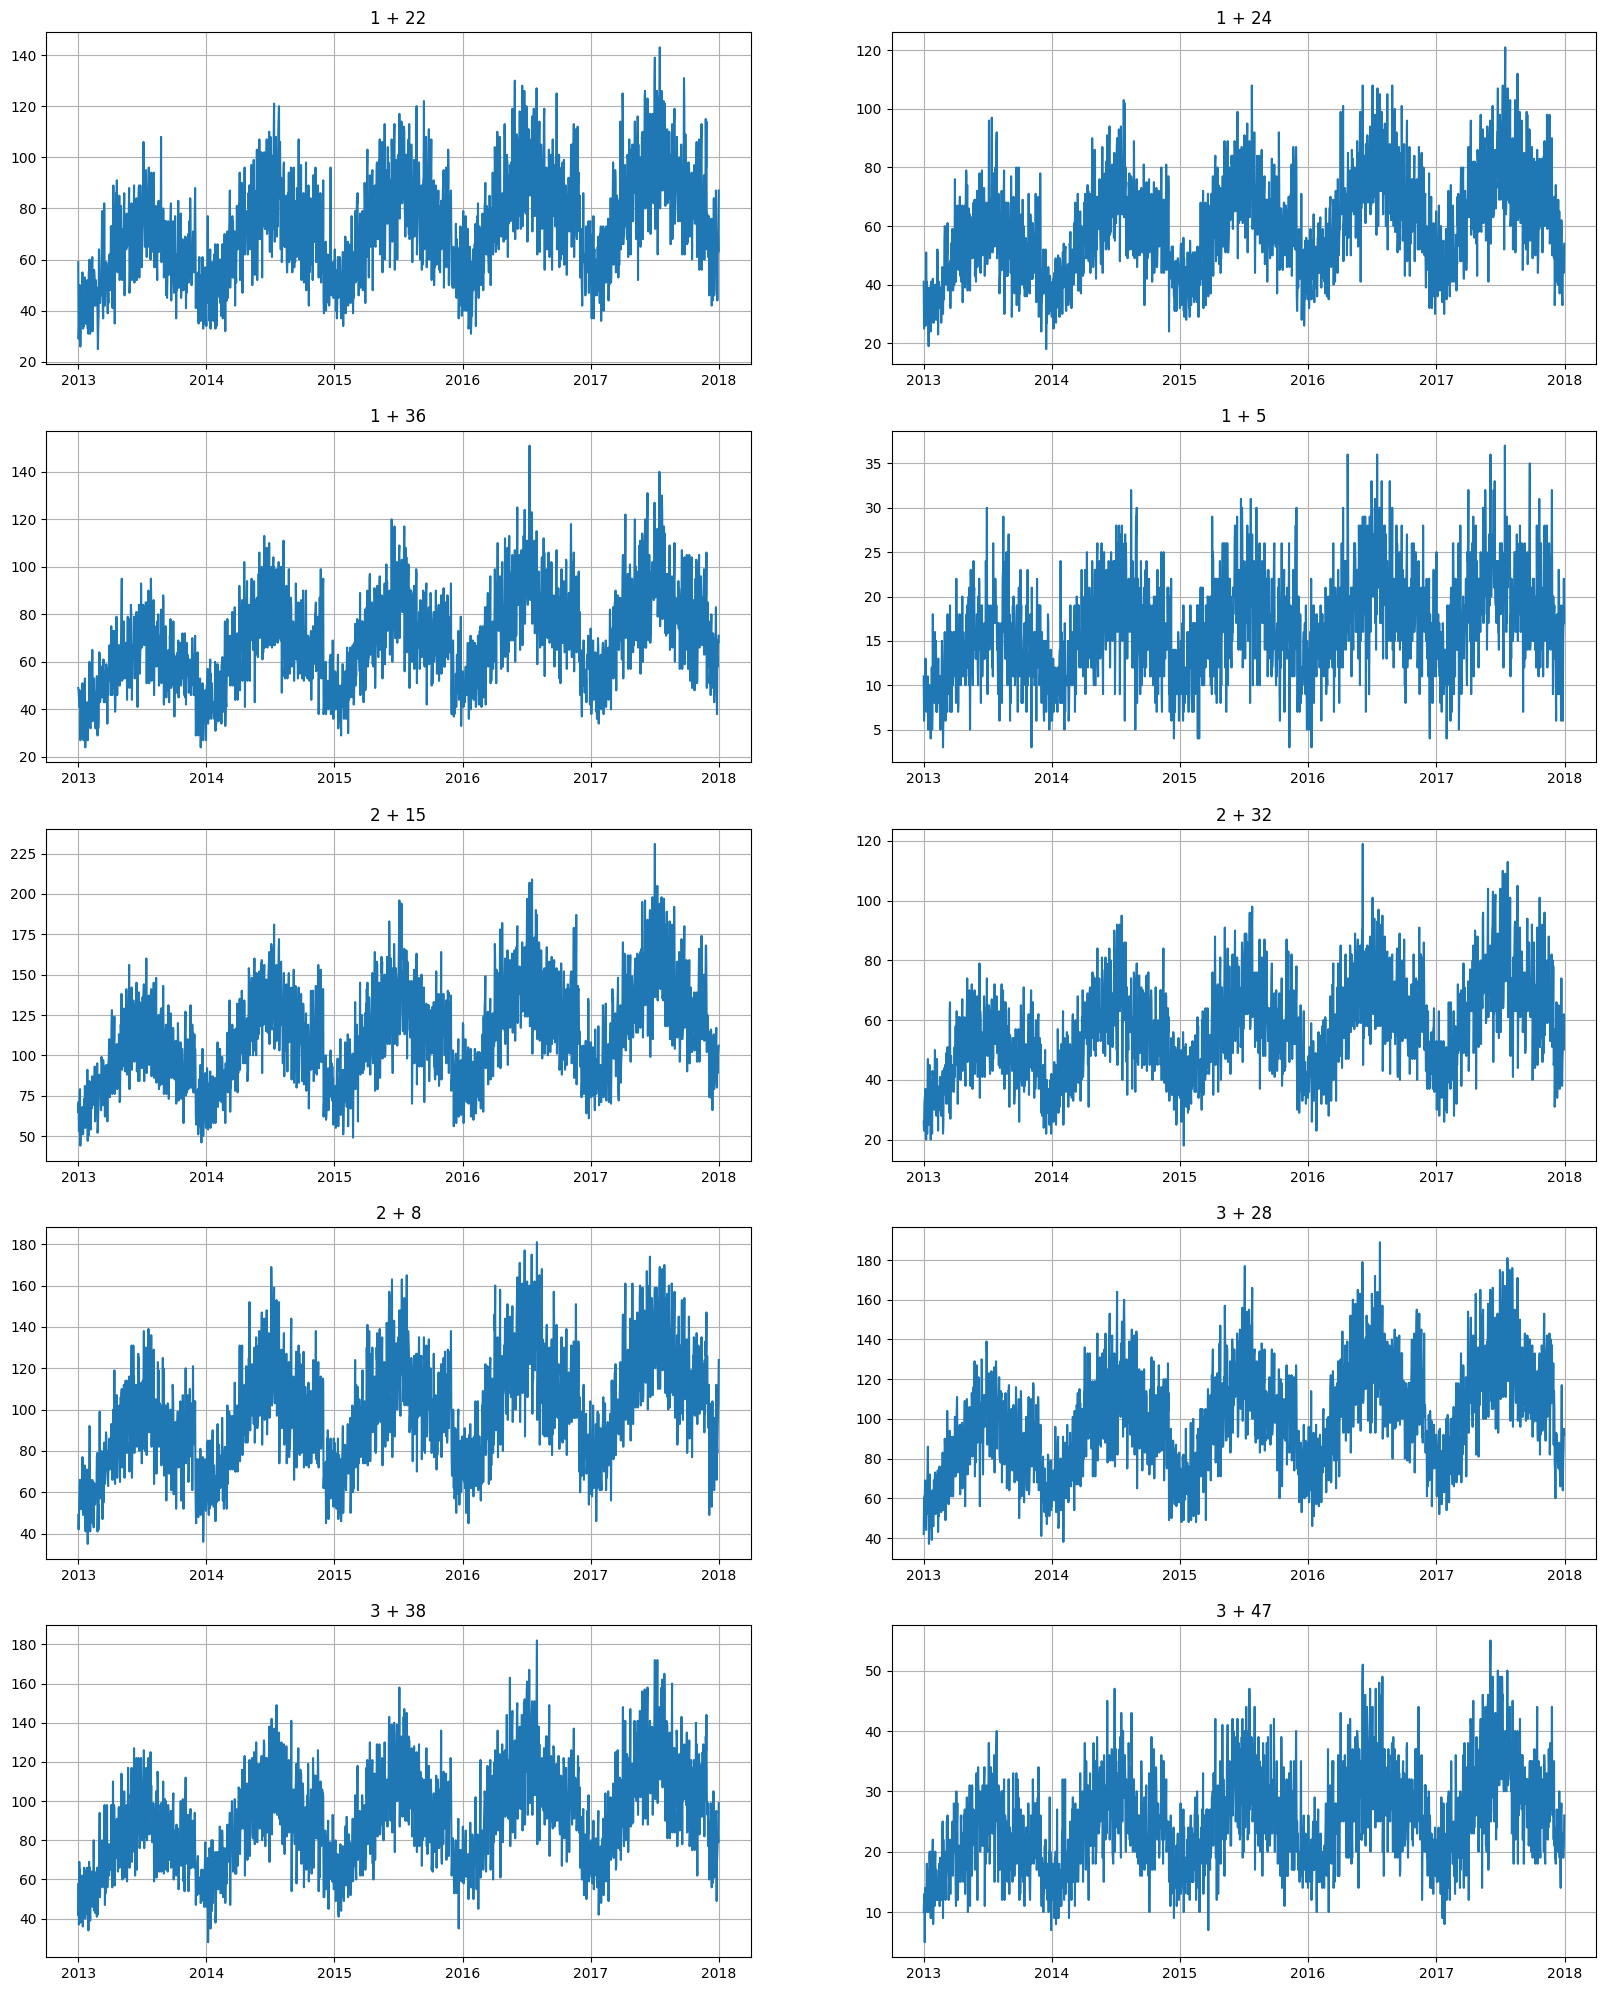

In [ ]:
ts.plot()

In [ ]:
ts.describe()

,start_timestamp,end_timestamp,length,num_missing,num_segments,num_exogs,num_regressors,num_known_future,freq
segments,,,,,,,,,
1 + 1,2013-01-01,2017-12-31,1826,0,150,5,5,5,D
1 + 10,2013-01-01,2017-12-31,1826,0,150,5,5,5,D
1 + 11,2013-01-01,2017-12-31,1826,0,150,5,5,5,D
1 + 12,2013-01-01,2017-12-31,1826,0,150,5,5,5,D
1 + 13,2013-01-01,2017-12-31,1826,0,150,5,5,5,D
...,...,...,...,...,...,...,...,...,...
3 + 50,2013-01-01,2017-12-31,1826,0,150,5,5,5,D
3 + 6,2013-01-01,2017-12-31,1826,0,150,5,5,5,D
3 + 7,2013-01-01,2017-12-31,1826,0,150,5,5,5,D


In [ ]:
from etna.analysis import acf_plot
from etna.analysis import plot_correlation_matrix

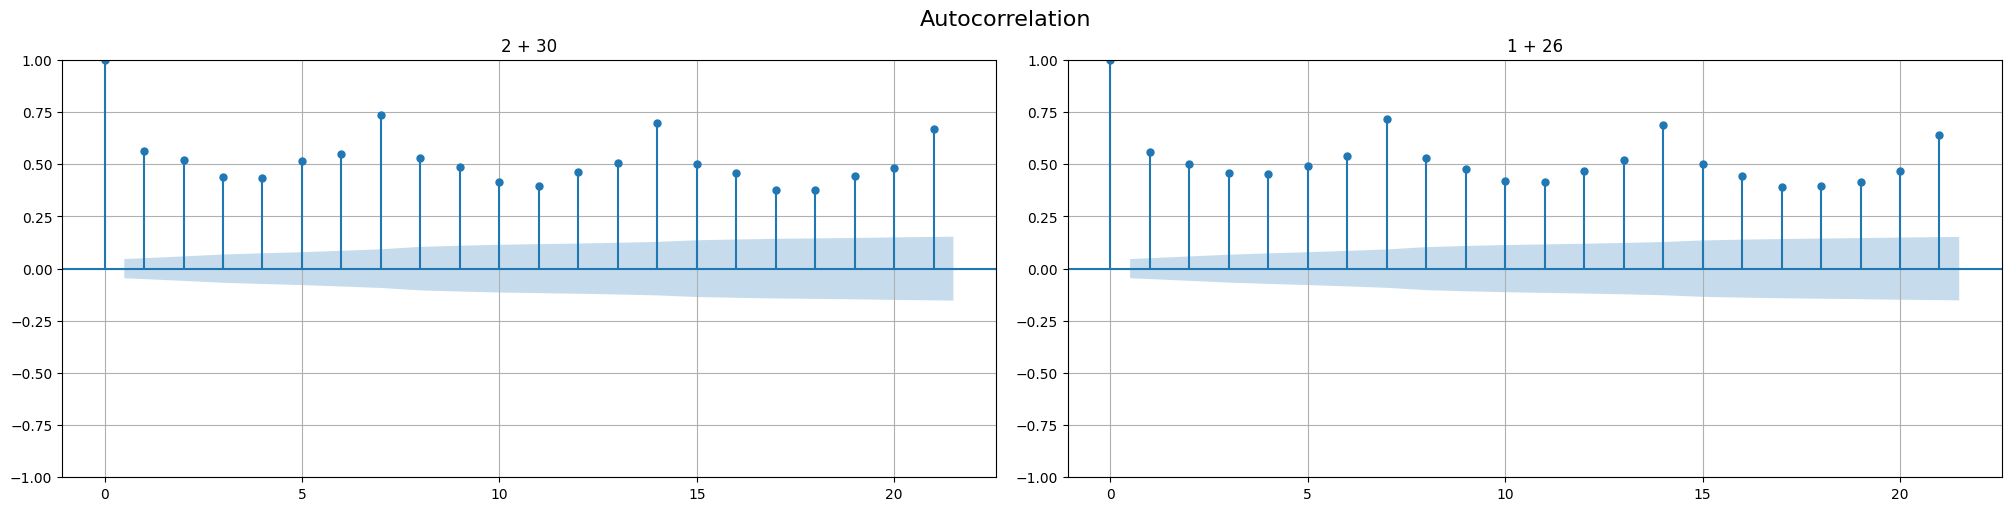

In [ ]:
acf_plot(ts, lags=21, n_segments=2)

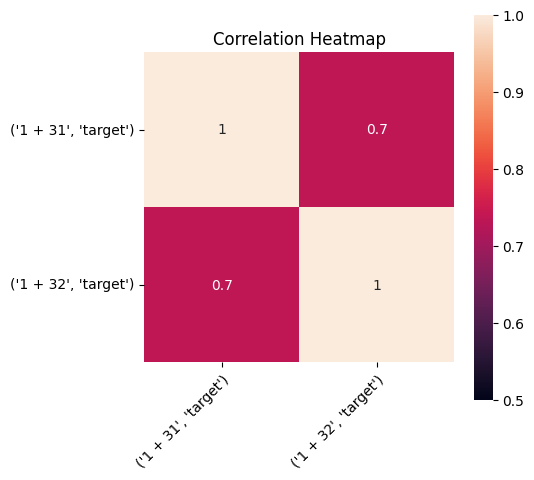

In [ ]:
plot_correlation_matrix(ts, columns=['target'], segments=['1 + 31', "1 + 32", "10 + 49"],
                        method="spearman", vmin=0.5, vmax=1, figsize=(5,5))

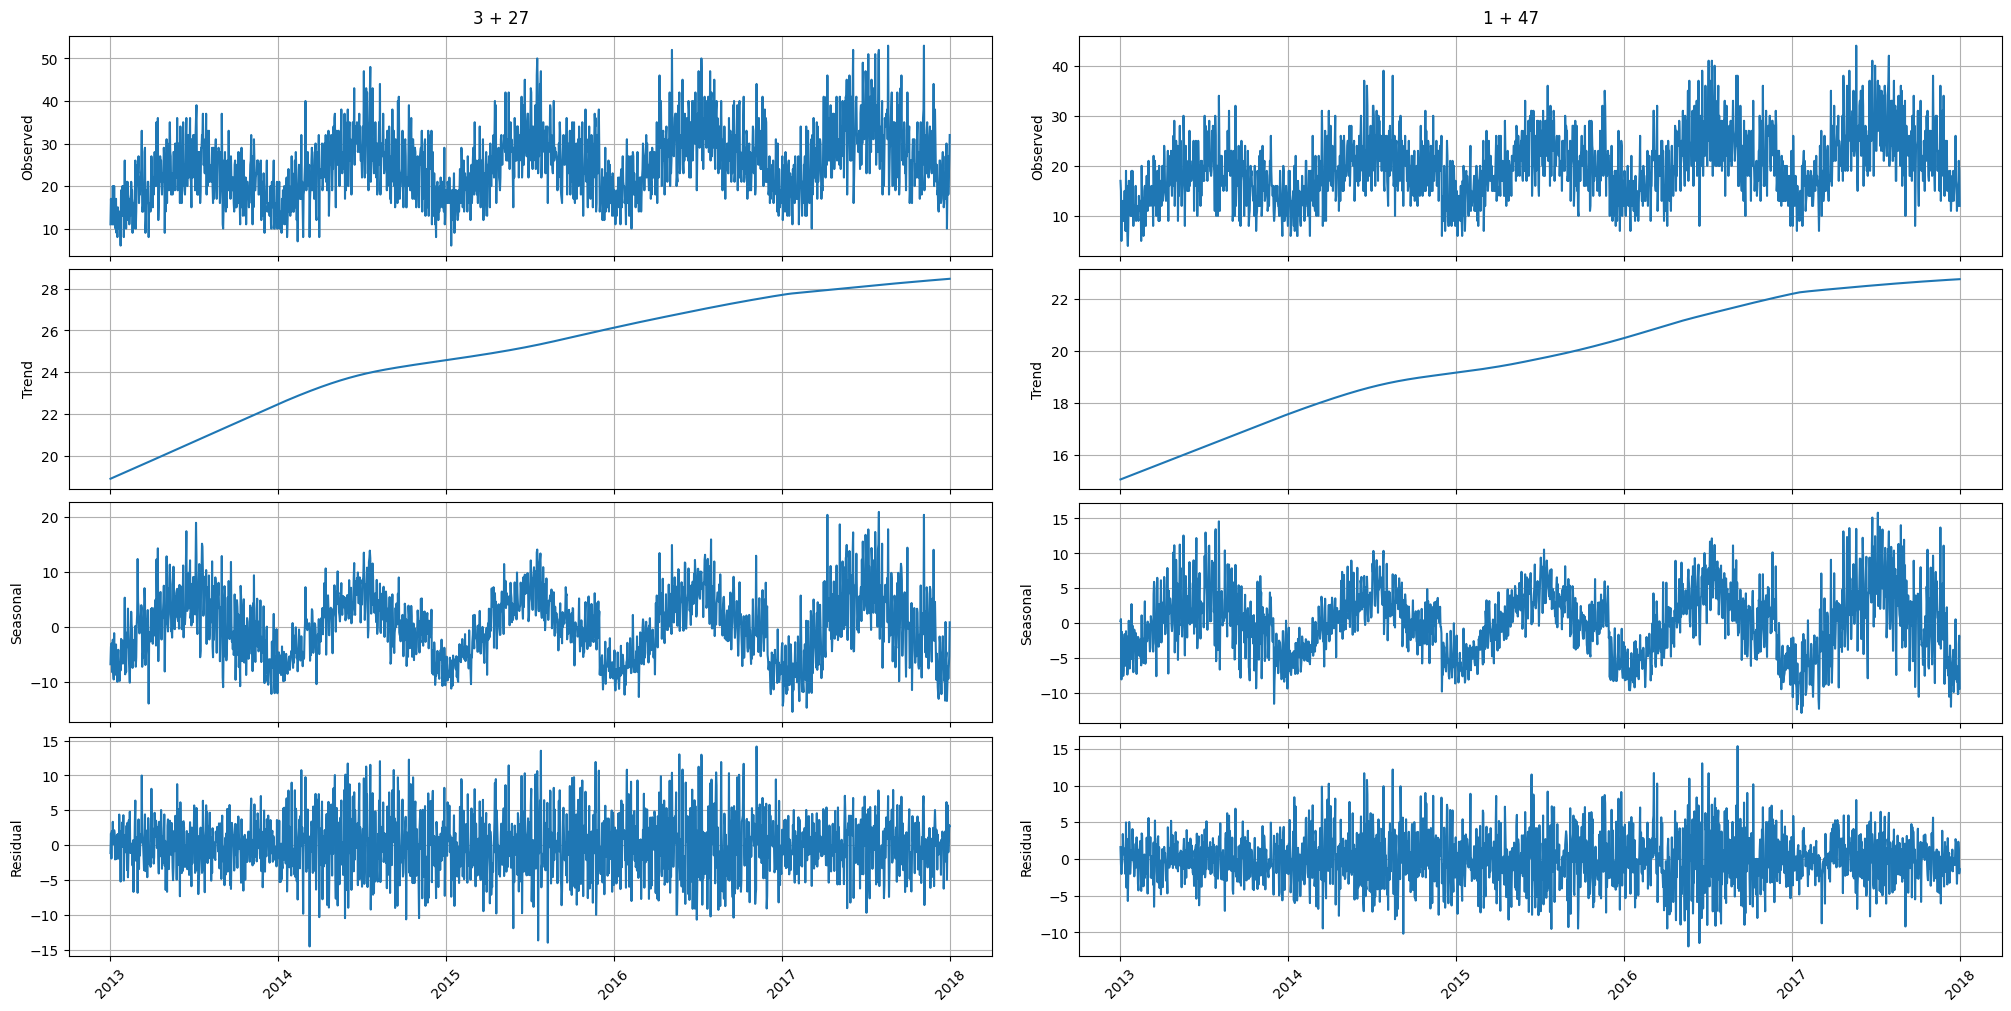

In [ ]:
from etna.analysis import stl_plot

stl_plot(ts=ts, period=365, segments=SEGMENTS_TO_SHOW)

# 0. Naive Model

Avg (by segments) metric SMAPE(mode = <MetricAggregationMode.per_segment: 'per-segment'>, ) is: 27.94174347082239


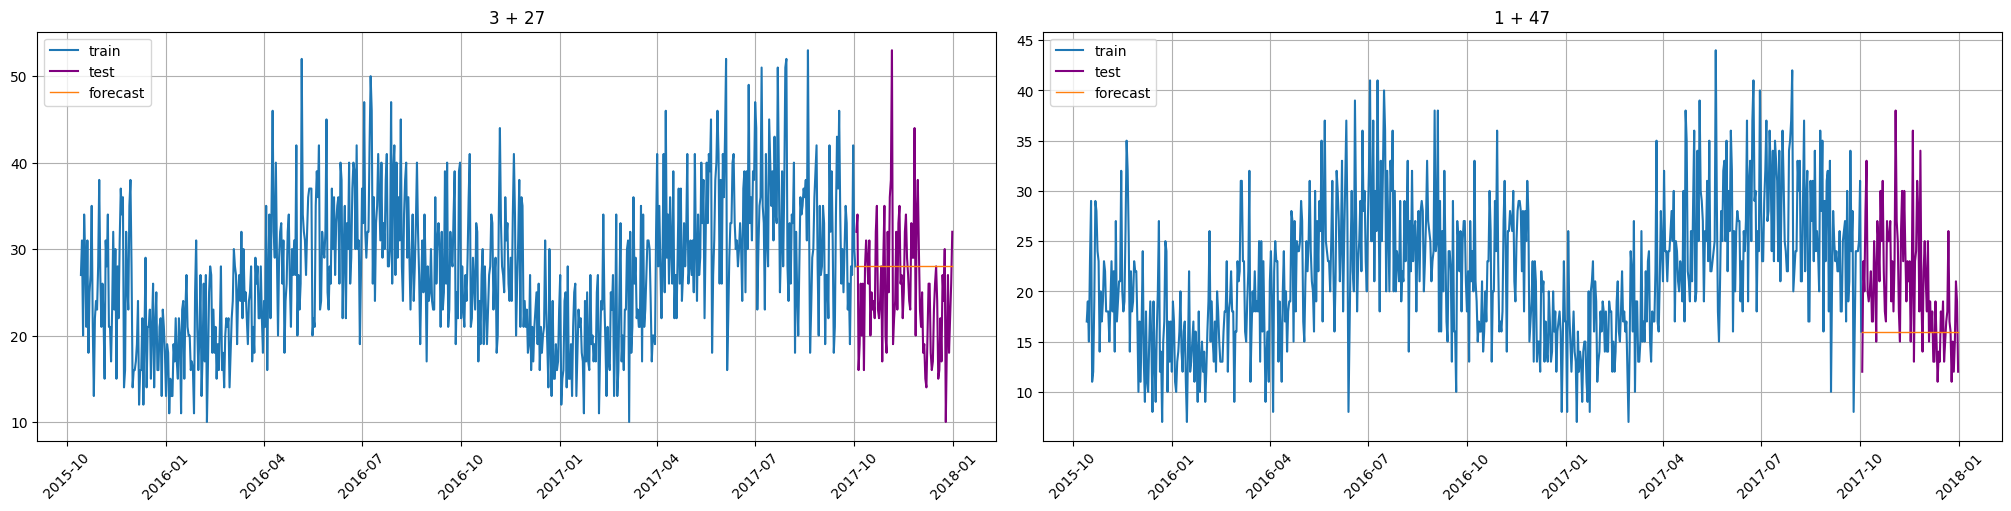

In [ ]:
from etna.models import NaiveModel

naive_model_recursive_metrics = train_and_evaluate_model(
    ts=ts,
    model=NaiveModel(),
    transforms=[],
    horizon=HORIZON,
    metrics=smape,
    is_auto_regressive=True,
    print_metrics=True,
    )

Avg (by segments) metric SMAPE(mode = <MetricAggregationMode.per_segment: 'per-segment'>, ) is: 27.94174347082239


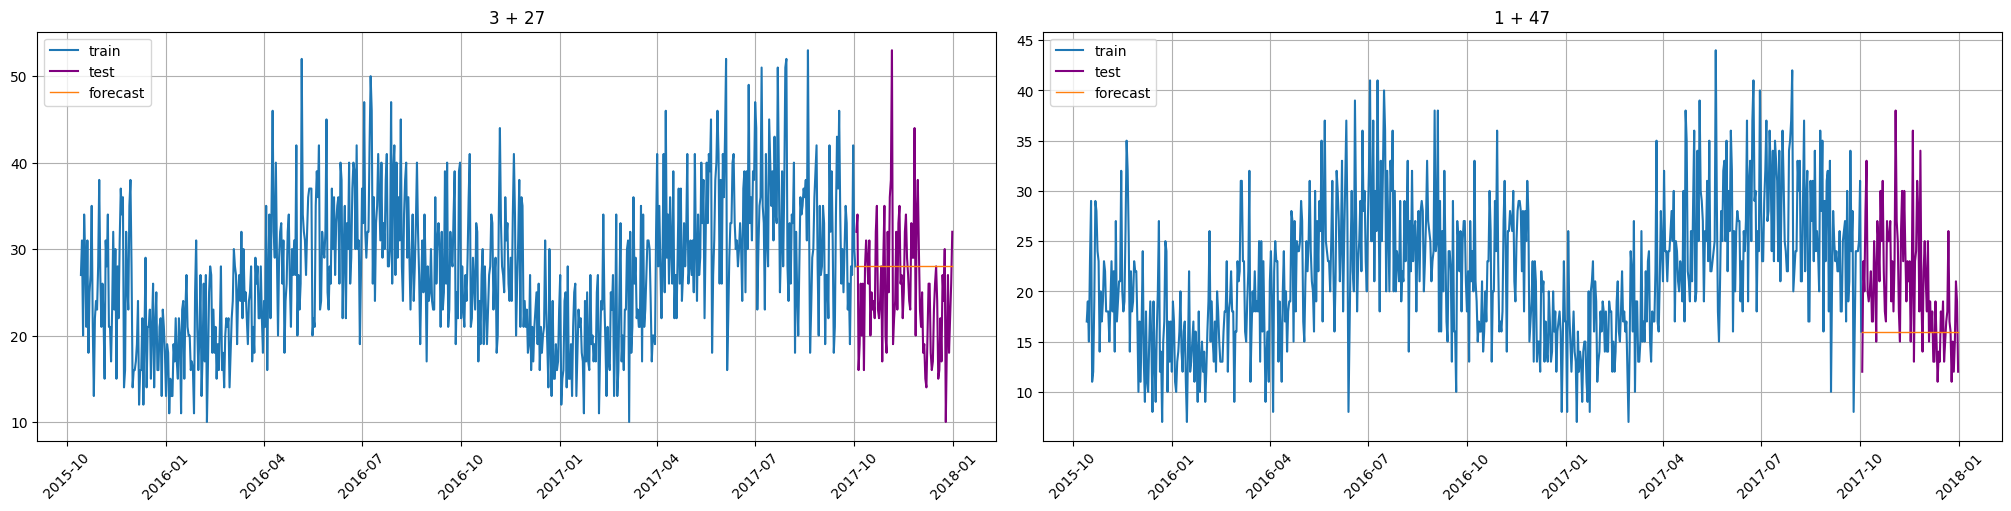

In [ ]:
from etna.models import NaiveModel

naive_model_NON_recursive_metrics = train_and_evaluate_model(
    ts=ts,
    model=NaiveModel(),
    transforms=[],
    horizon=HORIZON,
    metrics=smape,
    is_auto_regressive=False,
    print_metrics=True,
    )

# 1. Linear Model

Avg (by segments) metric SMAPE(mode = <MetricAggregationMode.per_segment: 'per-segment'>, ) is: 19.218794779261113


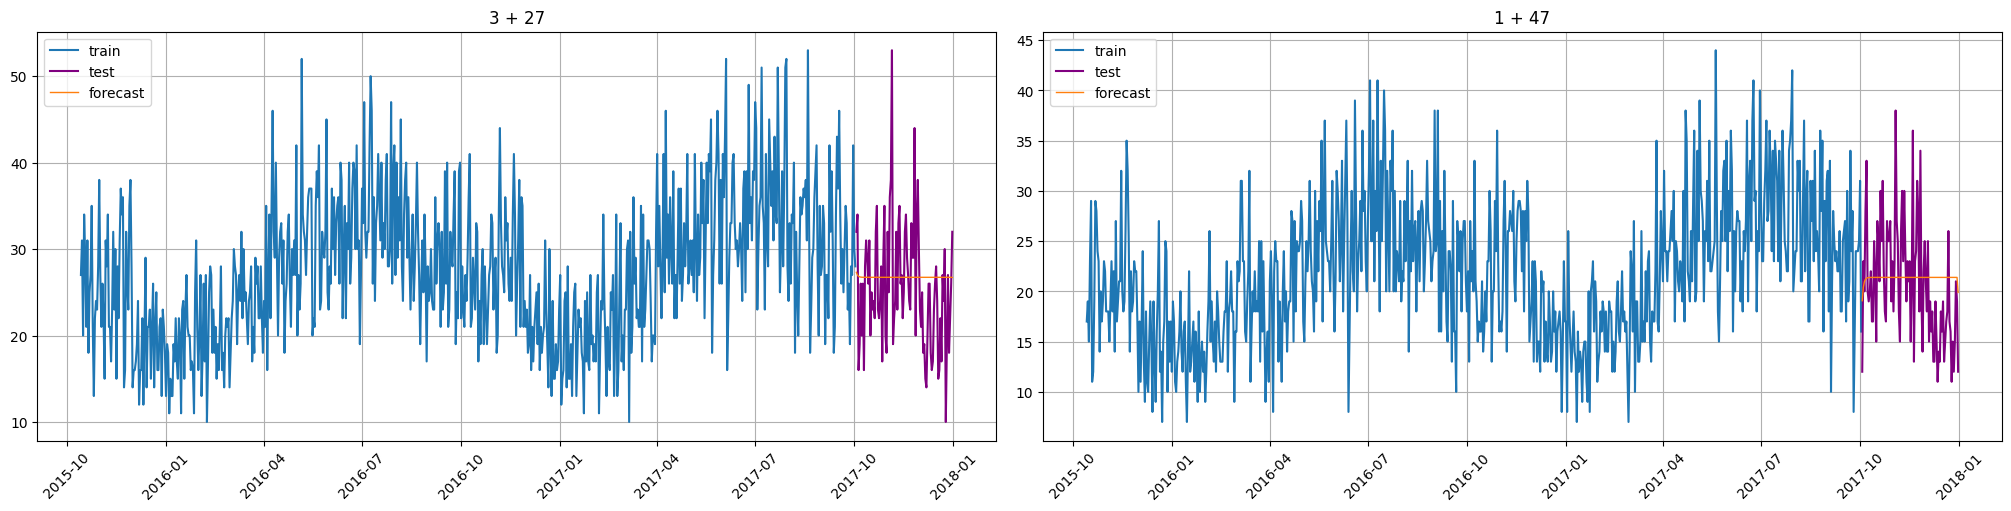

In [ ]:
# занимает ~10 минут, так как мы используем рекурсивный пайплайн (который работает медленно)
from etna.models import ElasticPerSegmentModel

standardscaler = StandardScalerTransform(in_column=None)

mean7 = MeanTransform(in_column='target',
                      window=7,
                      out_column='mean_7')


lags = LagTransform(in_column='target',
                    lags=[1],
                    out_column='lag')

elast_transforms = [lags, mean7, standardscaler]


linear_model_metrics = train_and_evaluate_model(
    ts=ts,
    model=ElasticPerSegmentModel(l1_ratio=0, alpha=0,
                                 random_state=42),
    transforms=elast_transforms,
    horizon=HORIZON,
    metrics=smape,
    is_auto_regressive=True,
    print_metrics=True
    )

# Conclusion

In [ ]:
model_res = {
    'naive_model_recursive_metrics': naive_model_recursive_metrics,
    'linear_model_metrics': linear_model_metrics,
}

res = pd.DataFrame({'model': list(model_res.keys()),
                    'avg_metric': [model_res[model][1] for model in model_res.keys()],
                    'segment_metrics': [model_res[model][0] for model in model_res.keys()]})

In [ ]:
res

,model,avg_metric,segment_metrics
0,naive_model_recursive_metrics,27.941743,1 + 1 50.912771 1 + 10 19.040035 1 + 11...
1,linear_model_metrics,19.218795,1 + 1 24.093211 1 + 10 18.726604 1 + 11...


## Backtest

In [ ]:
# тоже выполняется порядка 10 минут

from etna.pipeline import AutoRegressivePipeline

pipe = AutoRegressivePipeline(
    model=ElasticPerSegmentModel(l1_ratio=0, alpha=0,
                                 random_state=42),
    transforms=elast_transforms,

    horizon=HORIZON)

metrics_df, _, _ = pipe.backtest(
    mode='expand',
    n_folds=5,
    ts=ts,
    metrics=[smape],
    aggregate_metrics=True,
    joblib_params=dict(backend='loky'),
    n_jobs=-1
)


In [ ]:
metrics_df.head(8)
metric = metrics_df['SMAPE'].mean()

In [ ]:
print(f'mean SMAPE: {metric:.4f}')

mean SMAPE: 22.8238


In [18]:
from etna.models import ProphetModel, CatBoostMultiSegmentModel, ElasticPerSegmentModel
from etna.transforms import RobustScalerTransform, FourierTransform

In [22]:
mean7 = MeanTransform(in_column='target', window=7, out_column='mean_7')
mean14 = MeanTransform(in_column='target', window=14, out_column='mean_14')
mean30 = MeanTransform(in_column='target', window=30, out_column='mean_30')
mean5 = MeanTransform(in_column='target', window=5, out_column='mean_5')
lags = LagTransform(in_column='target', lags=list(range(1, 15)), out_column='lag')
robust_scaler = RobustScalerTransform(in_column='target')
fourier = FourierTransform(in_column='target', period=7, order=3, out_column='fourier_3')

# трансформеры
nonlinear_transforms = [
    mean7, mean14, mean30, mean5,
    lags, robust_scaler, fourier
]

In [23]:
# Словарь для хранения метрик моделей
model_res = {}

# 1. Prophet Model
prophet_pipeline = AutoRegressivePipeline(
    model=ProphetModel(),
    transforms=nonlinear_transforms,
    horizon=HORIZON
)
prophet_metrics, _, _ = prophet_pipeline.backtest(
    mode='expand', n_folds=5, ts=ts, metrics=[smape], aggregate_metrics=True, n_jobs=-1
)
model_res['Prophet'] = (prophet_metrics, prophet_metrics['SMAPE'].mean())

Выходные данные были обрезаны до нескольких последних строк (5000).
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=26077', 'data', 'file=/tmp/tmpkqw61x53/fwkcbofk.json', 'init=/tmp/tmpkqw61x53/a1n5lp1u.json', 'output', 'file=/tmp/tmpkqw61x53/prophet_modelfumuxlen/prophet_model-20241106132746.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:27:46 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkqw61x53/x9kmvj01.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=21497', 'data', 'file=/tmp/tmpkqw61x53/ebn48pp9.json', 'init=/tmp/tmpkqw61x53/x9kmvj01.json', 'output', 'file=/tmp/tmpkqw61x53/prophet_model7ruzu8v4/prophet

In [24]:
# 2. Линейная модель ElasticPerSegmentModel
elastic_pipeline = AutoRegressivePipeline(
    model=ElasticPerSegmentModel(l1_ratio=0, alpha=0, random_state=42),
    transforms=nonlinear_transforms,
    horizon=HORIZON
)

# Обратное тестирование для оценки модели ElasticPerSegmentModel
elastic_metrics, _, _ = elastic_pipeline.backtest(
    mode='expand',
    n_folds=5,
    ts=ts,
    metrics=[smape],
    aggregate_metrics=True,
    n_jobs=-1
)

# Сохранение результатов для ElasticPerSegmentModel
model_res['Elastic'] = (elastic_metrics, elastic_metrics['SMAPE'].mean())

[Parallel(n_jobs=-1)]: Using backend MultiprocessingBackend with 96 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   16.4s
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   16.6s remaining:   25.0s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   17.3s remaining:   11.5s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   17.7s finished
[Parallel(n_jobs=-1)]: Using backend MultiprocessingBackend with 96 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  7.2min
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  7.3min remaining: 11.0min
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:  7.4min remaining:  4.9min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  7.6min finished
[Parallel(n_jobs=-1)]: Using backend MultiprocessingBackend with 96 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   18.8s
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   18.9s remaining:   28.4s
[Pa

In [25]:
# Определение трансформеров
mean7 = MeanTransform(in_column='target', window=7, out_column='mean_7')
mean14 = MeanTransform(in_column='target', window=14, out_column='mean_14')
mean30 = MeanTransform(in_column='target', window=30, out_column='mean_30')
lags = LagTransform(in_column='target', lags=[1, 2, 3, 4, 5], out_column='lag')

# Комбинированные трансформеры
nonlinear_transforms = [
    mean7, mean14, mean30,
    lags]

In [26]:
# 3. CatBoost Model
catboost_pipeline = AutoRegressivePipeline(
    model=CatBoostMultiSegmentModel(
        iterations=680,
        learning_rate=0.011343191045977762,
        depth=9,
        l2_leaf_reg=5.156272517533989,
        bagging_temperature=0.16052146592832706,
        early_stopping_rounds=36,
        random_state=42,
        eval_metric='SMAPE'
    ),
    transforms=nonlinear_transforms,
    horizon=HORIZON
)
catboost_metrics, _, _ = catboost_pipeline.backtest(
    mode='expand', n_folds=5, ts=ts, metrics=[smape], aggregate_metrics=True, n_jobs=-1
)
model_res['CatBoost'] = (catboost_metrics, catboost_metrics['SMAPE'].mean())


[Parallel(n_jobs=-1)]: Using backend MultiprocessingBackend with 96 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  1.6min remaining:  2.4min
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:  1.6min remaining:  1.1min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.7min finished
[Parallel(n_jobs=-1)]: Using backend MultiprocessingBackend with 96 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  4.6min remaining:  7.0min
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:  4.7min remaining:  3.1min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  4.8min finished
[Parallel(n_jobs=-1)]: Using backend MultiprocessingBackend with 96 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   20.1s
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   20.3s remaining:   30.4s
[Pa

In [27]:
res = pd.DataFrame({
    'model': list(model_res.keys()),
    'avg_metric': [model_res[model][1] for model in model_res.keys()],
    'segment_metrics': [
        ', '.join(f"{segment} {value:.6f}" for segment, value in model_res[model][0]['SMAPE'].items())
        for model in model_res.keys()
    ]
})

print(res)

      model  avg_metric                                    segment_metrics
0   Prophet   12.296759  0 19.292522, 1 10.818029, 2 11.100863, 3 10.54...
1   Elastic   16.694651  0 23.074299, 1 15.718414, 2 15.617528, 3 14.79...
2  CatBoost   19.832173  0 24.616689, 1 21.096246, 2 17.872111, 3 17.72...


Трансформеры:

MeanTransform: усреднение по окнам различной длины (7, 14, 30, 5) для добавления скользящих средних значений. Это помогает сгладить временной ряд и выявить тренды на разных временных интервалах.

LagTransform: добавление лагов (запаздываний) на основе целевого столбца, что позволяет модели учитывать предыдущие значения ряда при прогнозировании.

RobustScalerTransform: масштабирование данных для уменьшения влияния выбросов. В сравнении со StandartScalerTransform показал лучшие результаты.

FourierTransform: извлечение сезонных компонент на основе частоты (период 7 и порядок 3), что помогает учесть недельные циклы.

Оптимизация гиперпараметров:

Для CatBoostMultiSegmentModel гиперпараметры (такие как iterations, learning_rate, depth, l2_leaf_reg) были настроены с помощью библиотеки Optuna, что позволило улучшить метрику SMAPE с 24 до 19.

Для ProphetModel гиперпараметры также подбирались, но улучшения метрики не было достигнуто.

Кросс-валидация:

Кросс-валидация по расширяющимся окнам (expand mode) с 5 фолдами была применена ко всем моделям. Это позволяет оценить устойчивость модели на временных рядах и избежать переобучения.

В итоге, применение и комбинация трансформеров дала ниболее оптимальтный вариант SMAPE 12.29 Prophet модель.